In [1]:
from pathlib import Path
path_to_data_notebook = Path.cwd().parent.parent / "Data" / "1_Preprocesed_data.ipynb"
%run {path_to_data_notebook}

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import datetime 
import time
from sklearn.model_selection import train_test_split

2025-03-19 20:00:03.416055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742410803.434961    7787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742410803.440724    7787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 20:00:03.460625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
size = 35
x_range_to_cut = 0.001
df = get_whole_preprocessed_dataframe(size, x_range_to_cut)
# choosen property for y:
choosen_property_1 = "Total_surface_area[m2/g]"
choosen_property_2 = "Total_pore_volume[cm3/g]"
choosen_property_3 = "Micropore_volume[cm3/g]"

df_with_data = df[(df[choosen_property_1].notna()) & (df[choosen_property_2].notna()) & (df[choosen_property_3].notna())] # get data if all 3 choosen property are present
df_without_data = df[(df[choosen_property_1].isna()) | (df[choosen_property_2].isna()) | (df[choosen_property_3].isna())] # get data if only one choosen property are missing

X = df_with_data['processed_flatten_isotherm_X_Y'] # x = 'processed_flatten_isotherm_X_Y'
y = df_with_data # y - temporary all columns for prediction inspection, in next steps we extract only choosen property

X_train, X_test, y_train_nested, y_test_nested, = train_test_split(X, y, test_size=0.02, random_state=42) #random_state=42

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train_nested[[choosen_property_1,choosen_property_2,choosen_property_3]].to_numpy()
y_test = y_test_nested[[choosen_property_1,choosen_property_2,choosen_property_3]].to_numpy() 


scaler = StandardScaler() # only for x data
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

print(f'X_train size = {len(X_train)}')
print(f'y_train size = {len(X_train)}')
print(f'X_test size = {len(X_test)}')
print(f'y_test size = {len(X_test)}')

/home/pc/moje/python_projects/adsorbents_isotherms/Data/all_data.csv
------------------------------- Preprocessing_data start -------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Article_name                    1011 non-null   object 
 1   Figure_number                   1011 non-null   object 
 2   Sample_name                     1011 non-null   object 
 3   Total_surface_area[m2/g]        928 non-null    float64
 4   Total_pore_volume[cm3/g]        778 non-null    float64
 5   Micropore_volume[cm3/g]         730 non-null    float64
 6   Mesopore_volume[cm3/g]          21 non-null     float64
 7   Average_pore_diameter[nm]       121 non-null    float64
 8   Impregnation_ratio[agent/char]  20 non-null     float64
 9   Activation_type                 33 non-null     object 
 10

In [141]:
X_without = df_without_data['processed_flatten_isotherm_X_Y'].tolist()
X_without = scaler.transform(X_without) 

y_without = df_without_data[[choosen_property_1,choosen_property_2,choosen_property_3]].to_numpy()

In [17]:
# print(y)

In [58]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [59]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [60]:
def calculate_time(transcription_time):
    timedelta_obj = datetime.timedelta(seconds=int(transcription_time))
    return str(timedelta_obj)

In [61]:
epochs_number = 500

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(size, activation='relu'), 
    tf.keras.layers.Dense(1400, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(3)                      
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics=['mae', 'mse']
model.compile(optimizer=optimizer, loss='mae', metrics=metrics)



# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# history  =  model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2)
start = time.time()
history  =  model.fit(X_train, y_train, epochs=epochs_number, batch_size=32, validation_split=0.1, verbose=2)
end = time.time()
transcription_time = calculate_time(round((end - start),2))
print(f"Model training time: "+transcription_time)
model.summary()
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")




Epoch 1/500


I0000 00:00:1742413460.579655    7787 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:09:00.0, compute capability: 7.5
I0000 00:00:1742413461.821327    8980 service.cc:148] XLA service 0x73df1000c990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742413461.821463    8980 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-03-19 20:44:21.866517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742413462.041283    8980 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742413462.899455    8980 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 3s - 191ms/step - loss: 336.7921 - mae: 336.7921 - mse: 466725.7500 - val_loss: 316.4561 - val_mae: 316.4561 - val_mse: 441747.0625
Epoch 2/500
18/18 - 0s - 5ms/step - loss: 303.7208 - mae: 303.7208 - mse: 392324.1875 - val_loss: 243.1781 - val_mae: 243.1781 - val_mse: 264024.1250
Epoch 3/500
18/18 - 0s - 5ms/step - loss: 182.2293 - mae: 182.2293 - mse: 150321.3125 - val_loss: 131.1533 - val_mae: 131.1533 - val_mse: 123046.0781
Epoch 4/500
18/18 - 0s - 6ms/step - loss: 121.6810 - mae: 121.6810 - mse: 69036.6797 - val_loss: 118.6075 - val_mae: 118.6075 - val_mse: 66881.0078
Epoch 5/500
18/18 - 0s - 5ms/step - loss: 106.7264 - mae: 106.7264 - mse: 53020.6875 - val_loss: 94.7507 - val_mae: 94.7507 - val_mse: 56143.9531
Epoch 6/500
18/18 - 0s - 5ms/step - loss: 99.2726 - mae: 99.2726 - mse: 45941.3164 - val_loss: 85.8981 - val_mae: 85.8981 - val_mse: 46871.0430
Epoch 7/500
18/18 - 0s - 5ms/step - loss: 94.8266 - mae: 94.8266 - mse: 43256.9453 - val_loss: 83.1960 - val_mae: 83.1960 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1400)           │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       140,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,326 (2.24 MB)

 Trainable params: 196,108 (766.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 392,218 (1.50 MB)

Metrics: [14.913285255432129, 14.913285255432129, 1069.0146484375]
mae = 14.913285255432129
mse = 1069.0146484375


Model training time without gpu, epoch = 1000 : 0:01:10

Metrics: [14.913285255432129, 14.913285255432129, 1069.0146484375]
mae = 14.913285255432129
mse = 1069.0146484375


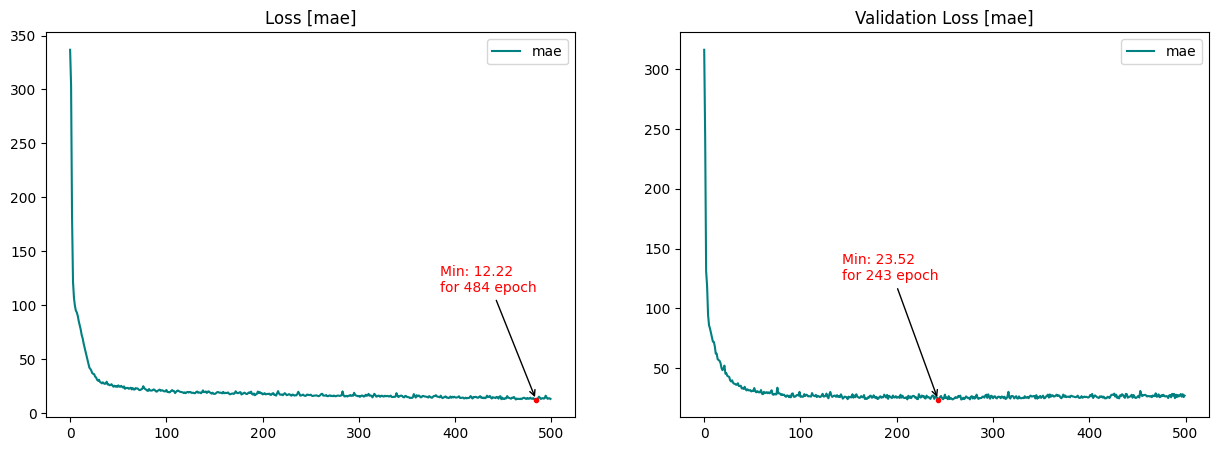

In [62]:
results = model.evaluate(X_test, y_test, verbose=0)
print("Metrics:",results)
for index, metric in enumerate(metrics):
    print(f"{metric} = {results[index+1]}")

from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

min_loss_idx = history.history['loss'].index(min(history.history['loss']))
min_loss = min(history.history['loss'])# Get the lowest  value
ax[0].plot(history.history['loss'], color='teal', label='mae')
# ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss [mae]')
ax[0].legend()
ax[0].annotate(f'Min: {min_loss:.2f} \nfor {min_loss_idx} epoch', 
               xy=(min_loss_idx, min_loss), 
               xytext=(min_loss_idx - 100, min_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[0].plot(min_loss_idx, min_loss, 'ro',markersize=3)# Plot a dot at the minimum point


min_val_loss_idx = history.history['val_loss'].index(min(history.history['val_loss']))# Find the index of the minimum 
min_val_loss = min(history.history['val_loss'])# Get the lowest  value
ax[1].plot(history.history['val_loss'], color='teal', label='mae')
# ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Validation Loss [mae]')
ax[1].legend()
# Annotate the lowest point on the validation loss curve
ax[1].annotate(f'Min: {min_val_loss:.2f} \nfor {min_val_loss_idx} epoch', 
               xy=(min_val_loss_idx, min_val_loss), 
               xytext=(min_val_loss_idx - 100, min_val_loss + 100),  # Adjust text position
               arrowprops=dict(facecolor='red', arrowstyle="->"),
               color='red')
ax[1].plot(min_val_loss_idx, min_val_loss, 'ro', markersize=3)# Plot a dot at the minimum point

# ax[2].plot(history.history['val_mse'], color='teal', label='regress loss')
# # ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# ax[2].title.set_text('Validation mse')
# ax[2].legend()

plt.show()

In [109]:
predictions = model.predict(X_test, verbose=0)
print(f'predicted: {predictions[0][0]:.2f} {predictions[0][1]:.2f} {predictions[0][2]:.2f}')
print(f'true:      {y_test[0][0]:.2f} {y_test[0][1]:.2f} {y_test[0][2]:.2f}')
print(f'Article: {y_test_nested.iloc[0,0]}, Figure nb: {y_test_nested.iloc[0,1]} Sample name: {y_test_nested.iloc[0,2]}')
# print(y_test_nested.loc[0,['Article_name']])

predicted: 1418.94 1.91 0.78
true:      1343.00 0.93 0.70
Article: Data150, Figure nb: 4 Sample name: 10stC


In [126]:
error_threshold = 30
max_error_threshold = 30
predictions = model.predict(X_test, verbose=0)


for index in range(3):
    list_below =[]
    list_above=[]
    errors = []

    print(y_test_nested.columns[3+index])
    predictions_ = predictions[:,index]
    y_test_ = y_test[:,index]
    # predictions_ = predictions[:,0]
    # y_test_ = y_test[:,0]
    for i in range(len(predictions_)):
        errors.append(abs(predictions_[i] - y_test_[i]))
    
            
        if(error_threshold<=abs(predictions_[i] - y_test_[i])):
            list_above.append(i)
        else: list_below.append(i)
    
    for i in range(len(predictions)):
        print(f" przewidywana --> {predictions_[i]:.2f}     {y_test_[i]:.2f} <-- rzeczyswista     blad: {abs(predictions_[i] - y_test_[i]):.2f}         {y_test_nested.iloc[i,0]} {y_test_nested.iloc[i,1]} {y_test_nested.iloc[i,2]}")
    
    print(f"max error: {max(errors)}  dla {y_test_nested.iloc[errors.index(max(errors)),1]} " )
    print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions_))*100,2)}%     {len(list_below)} izotermy na {len(predictions_)} \n")

Total_surface_area[m2/g]
 przewidywana --> 1418.94     1343.00 <-- rzeczyswista     blad: 75.94         Data150 4 10stC
 przewidywana --> 915.47     910.00 <-- rzeczyswista     blad: 5.47         Data75 4_1 400stC
 przewidywana --> 1975.21     1951.00 <-- rzeczyswista     blad: 24.21         Data74 4 ACK-2-8
 przewidywana --> 2317.63     2227.00 <-- rzeczyswista     blad: 90.63         Data69 1 D3065013
 przewidywana --> 740.69     762.00 <-- rzeczyswista     blad: 21.31         Data43 6 F1-8-77
 przewidywana --> 148.04     26.00 <-- rzeczyswista     blad: 122.04         Data125 3 bengkirai_wood_400
 przewidywana --> 3362.87     3441.00 <-- rzeczyswista     blad: 78.13         Data103 4 4
 przewidywana --> 496.65     484.10 <-- rzeczyswista     blad: 12.55         Data54 2 Z0.15
 przewidywana --> 523.08     578.00 <-- rzeczyswista     blad: 54.92         Data126 1 AC-313.15-20-540-8
 przewidywana --> 544.32     535.37 <-- rzeczyswista     blad: 8.95         Data149 4 4M
 przewidywana -

In [147]:
predictions_for_data_without = model.predict(X_without, verbose=0)
for i in range(len(predictions_for_data_without)):
    print(f'{predictions_for_data_without[i][0]:.2f}    {predictions_for_data_without[i][1]:.2f}     {predictions_for_data_without[i][2]:.2f}  <---->  {y_without[i][0]:.2f}   {y_without[i][1]:.2f}   {y_without[i][2]:.2f}')

250.08    0.39     0.08  <---->  262.00   0.23   nan
490.70    0.66     0.17  <---->  598.60   0.38   nan
1512.36    1.91     0.80  <---->  1652.00   0.92   nan
1694.91    2.14     0.92  <---->  1905.00   1.06   nan
2886.44    3.69     1.43  <---->  2960.00   1.62   nan
1860.29    2.34     0.91  <---->  1905.00   1.06   nan
2289.89    3.03     1.08  <---->  2387.00   1.44   nan
175.44    0.30     0.02  <---->  548.00   nan   0.30
29.64    0.20     0.15  <---->  340.00   nan   0.26
371.23    0.44     0.16  <---->  482.00   nan   0.29
289.89    0.37     0.19  <---->  576.00   nan   0.34
1945.41    2.07     0.79  <---->  1872.00   nan   nan
2492.02    2.88     1.05  <---->  2746.00   nan   nan
1825.11    1.86     0.78  <---->  1741.00   nan   nan
1967.70    2.28     0.96  <---->  2196.00   nan   nan
736.19    0.94     0.34  <---->  56.00   nan   nan
2215.55    2.55     0.90  <---->  2331.00   nan   nan
637.56    0.89     0.37  <---->  618.00   nan   0.33
1776.28    2.74     0.67  <---->  

In [148]:
# model.save("saved_models/3output_s35_500_mae3400_maxerr-122_warstwy-size-1400-100-30.keras")

In [46]:
from tensorflow.keras.models import load_model
model_name = 'saved_models/model_s35_500_mae34_maxerr-121_warstwy-35-160-50.keras'
modelos = load_model(model_name)
predictions = modelos.predict(X_test, verbose=0)
print(f"len {len(X_test)}")
error_threshold = 30
max_error_threshold = 30
list_below =[]
list_above=[]
errors = []
for i in range(len(predictions)):
    errors.append(abs(predictions[i] - y_test[i]))
    # print(f"{i} {predictions[i]}  ------   {y_valid[i]}           blad: {abs(predictions[i] - y_valid[i])}")
    # if(abs(predictions[i] - y_test[i]) > max_error_threshold):
    #     print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        
    if(error_threshold<=abs(predictions[i] - y_test[i])):
        list_above.append(i)
    else: list_below.append(i)
print("\nALL:")
for i in range(len(predictions)):
    print(f" przewidywana --> {predictions[i]}     {y_test[i]} <-- rzeczyswista     blad: {abs(predictions[i] - y_test[i])}  {y_test_nested[i][1]}")
        


print(f"max error: {max(errors)}  dla {y_test_nested[errors.index(max(errors))][1]} " )
print(f"for error thteshold[{error_threshold}] - {round((len(list_below)/len(predictions))*100,2)}%     {len(list_below)} izotermy na {len(predictions)}")

len 18

ALL:
 przewidywana --> [971.2737]     1041.9 <-- rzeczyswista     blad: [70.62631836]  ['Data58', '850-45m', '5_4', 'II']
 przewidywana --> [395.97638]     378.0 <-- rzeczyswista     blad: [17.97637939]  ['Data115', 'CAC1900', '1', 'I']
 przewidywana --> [742.24585]     770.1 <-- rzeczyswista     blad: [27.85415039]  ['Data58', '800-1h', '5_3', 'II']
 przewidywana --> [1362.1091]     1343.0 <-- rzeczyswista     blad: [19.10913086]  ['Data150', '10stC', '4', 'I_II']
 przewidywana --> [590.9509]     659.0 <-- rzeczyswista     blad: [68.04907227]  ['Data7', 'RK-600', '3', 'I']
 przewidywana --> [776.3707]     817.2 <-- rzeczyswista     blad: [40.82927246]  ['Data58', '800-1h15m', '5_3', 'II']
 przewidywana --> [1479.6089]     1387.0 <-- rzeczyswista     blad: [92.60888672]  ['Data65', 'R2-500', '2_2', 'I_IV']
 przewidywana --> [2005.0792]     2064.0 <-- rzeczyswista     blad: [58.92077637]  ['Data59', 'CMS500', '2', 'I_II']
 przewidywana --> [457.05875]     448.0 <-- rzeczyswista 

In [ ]:
#  przewidywana --> [553.189]     249.0 <-- rzeczyswista     blad: [304.18903]  ['Data125', 'coconut_shells_6h', '7']
#  przewidywana --> [1967.7969]     1616.22 <-- rzeczyswista     blad: [351.5769]  ['Data153', 'GC-C04', '4']
#  przewidywana --> [1556.715]     1193.2 <-- rzeczyswista     blad: [363.515]  ['Data54', 'CZ0.65', '3']
#  przewidywana --> [1296.133]     938.0 <-- rzeczyswista     blad: [358.13306]  ['Data15', '3', '1']
#  przewidywana --> [732.7655]     1188.0 <-- rzeczyswista     blad: [455.2345]  ['Data156', 'MCAC-2-1', '4']
#  przewidywana --> [573.38586]     976.0 <-- rzeczyswista     blad: [402.61414]  ['Data47', 'ACF30M-HNO3', '3']
#  przewidywana --> [350.85513]     823.0 <-- rzeczyswista     blad: [472.14487]  ['Data86', 'ACZ3', '2']
# max error: [472.14487]  dla ['Data86', 'ACZ3', '2'] 
# for error thteshold[50] - 57.8%     100 izotermy na 173